In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [ ]:
# Load and Preprocess Data¶
# You will load the Fashion MNIST dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

# Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [ ]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)

In [ ]:
print("done")

done


In [ ]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
train_data

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [ ]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [ ]:
train_data

<MapDataset shapes: ((784,), ()), types: (tf.float32, tf.int64)>

In [ ]:
batch_size =64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size=batch_size)

In [ ]:
def base_model():

  inputs = tf.keras.Input(shape=(28*28,), name='ins')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense2')(x)
  outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
# Building Training Loop
# In this section you build your training loop consisting of training and validation sequences.

# The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case sparse categorical crossentropy) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

# You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [ ]:
def apply_grads(optimizer, model, x, y):
  with tf.GradientTape() as t:
    logits = model(x)
    loss_val = loss(y, logits)
  grads = t.gradient(loss_val, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  return logits, loss_val

In [ ]:
def train_onces():
  losses=[]
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch, y_batch) in enumerate(train):
    logits, loss_val = apply_grads(optimizer, model, x_batch, y_batch)
    losses.append(loss_val)

    train_acc_metric(y_batch, logits)
    pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_val)))
    pbar.update()
  return losses

In [ ]:
def validation():
  losses = []
  for x_val, y_val in test:
    val_logits = model(x_val)
    val_loss = loss(y_val, val_logits)
    losses.append(val_loss)

    val_acc_metric(y_val, val_logits)

    return losses

In [ ]:
model = base_model()

In [ ]:
epochs = 10
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
  print("start of epoch %d" %(epoch,))
  losses_train = train_onces()
  train_acc = train_acc_metric.result()

  losses_val = validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)

  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)


  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean),
                                                                                                                  float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()


start of epoch 0


Training loss for step 937: 0.2732: 100%|█████████▉| 937/938 


 Epoch 0: Train loss: 0.5366  Validation Loss: 0.2317, Train Accuracy: 0.8101, Validation Accuracy 0.9062
start of epoch 1


Training loss for step 937: 0.3869: 100%|█████████▉| 937/938 


 Epoch 1: Train loss: 0.3907  Validation Loss: 0.2030, Train Accuracy: 0.8592, Validation Accuracy 0.9531
start of epoch 2


Training loss for step 937: 0.3186: 100%|██████████| 938/938 


 Epoch 2: Train loss: 0.3538  Validation Loss: 0.2016, Train Accuracy: 0.8720, Validation Accuracy 0.9531
start of epoch 3


Training loss for step 937: 0.3556: 100%|█████████▉| 937/938 


 Epoch 3: Train loss: 0.3285  Validation Loss: 0.1833, Train Accuracy: 0.8806, Validation Accuracy 0.9219
start of epoch 4


Training loss for step 937: 0.3151: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.3100  Validation Loss: 0.1307, Train Accuracy: 0.8860, Validation Accuracy 0.9688
start of epoch 5


Training loss for step 937: 0.1623: 100%|██████████| 938/938 


 Epoch 5: Train loss: 0.2981  Validation Loss: 0.1299, Train Accuracy: 0.8899, Validation Accuracy 0.9531
start of epoch 6


Training loss for step 937: 0.6164: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2854  Validation Loss: 0.1261, Train Accuracy: 0.8950, Validation Accuracy 0.9688
start of epoch 7


Training loss for step 937: 0.1005: 100%|█████████▉| 937/938 


 Epoch 7: Train loss: 0.2734  Validation Loss: 0.1844, Train Accuracy: 0.8987, Validation Accuracy 0.9531
start of epoch 8


Training loss for step 937: 0.3293: 100%|██████████| 938/938 


 Epoch 8: Train loss: 0.2633  Validation Loss: 0.1535, Train Accuracy: 0.9007, Validation Accuracy 0.9375
start of epoch 9


Training loss for step 937: 0.2002: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.2563  Validation Loss: 0.1261, Train Accuracy: 0.9043, Validation Accuracy 0.9688


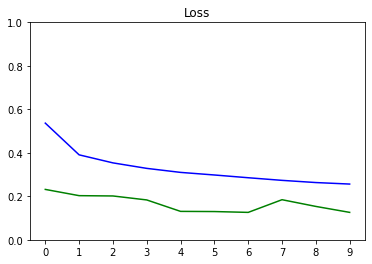

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [ ]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

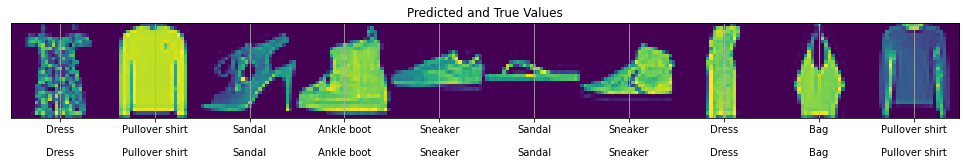

In [ ]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)